In [1]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cvxopt import matrix, solvers

In [2]:
def pos(s, state_space):
    """
    Given a particular value in a 2D matrix, returns the row and column number
    """
    return tuple(zip(*np.where(state_space == s)))[0]

In [3]:
def get_reward(reward_fn, s, state_space):
    """
    Returns the reward function value given a state
    """
    return reward_fn[pos(s, state_space)]

In [4]:
def get_neighbors(s, state_space):
    """
    Given a state, returns list of in-grid neighbors - left, right, up down
    """
    
    dim = state_space.shape[0]
    i, j = pos(s, state_space)
    neighbors = [state_space[i][j]]
    
    if i-1 >= 0: neighbors.append(state_space[i-1][j])
    if i+1 < dim: neighbors.append(state_space[i+1][j])
    if j-1 >= 0: neighbors.append(state_space[i][j-1])
    if j+1 < dim: neighbors.append(state_space[i][j+1])
        
    return neighbors

In [5]:
def get_cell_type(i, j, dim):
    """
    Identifies if a cell is corner/edge/non-boundary
    """
    
    if (i,j) in [(0, 0), (0, dim), (dim, 0), (dim, dim)]:
        return 'corner'
    
    elif i == 0 or j == 0 or i == dim or j == dim:
        return 'edge'
    
    else:
        return 'non-boundary'

In [6]:
def get_action_results(A, s, S, state_space, w, reward_fn, gamma, V):
    """
    Implements the summation in Line 10 of Value iteration
    """
    
    action_results = {}
    for a in A:
        action_results[a] = 0
        neighbors = get_neighbors(s, state_space)
        for s_dash in neighbors:
            p = get_transition_probability(state_space, s, s_dash, a, w, A)
            r = get_reward(reward_fn, s_dash, state_space)
            action_results[a] += p * (r + gamma * V[pos(s_dash, state_space)])

    return action_results

In [7]:
def get_relation(i, j, i_d, j_d):
    """
    Check if given cell lies to left, right, up or down of another cell. 
    Returns 'S' if both are same cell and None if not neighbors
    """
    
    if i == i_d:
        if j_d == j-1: 
            return 'L'
        elif j_d == j+1:
            return 'R'
        
        elif j_d == j:
            return 'S'
   
    elif j == j_d:
        if i_d == i-1:
            return 'U'
        elif i_d == i+1:
            return 'D'

In [8]:
def chk_edge_dir(i, j, a, n):
    return (i, a) in [(0, 'U'), (n, 'D')] or (j, a) in [(0, 'L'), (n, 'R')]

def chk_corner_dir(i, j, a, n):
    return (i, j, a) in [(0, 0, 'L'), (0, 0, 'U'),
                        (0, n, 'R'), (0, n, 'U'),
                        (n, 0, 'D'), (n, 0, 'L'),
                        (n, n, 'D'), (n, n, 'R')]

In [9]:
def get_transition_probability(state_space, s, s_dash, a, w, A):
    """
    Transition Probability Calculation
    """
    
    
    dim = state_space.shape[0] - 1
    
    i, j = pos(s, state_space)
    i_d, j_d = pos(s_dash, state_space)
    
    
    s_dash_dir = get_relation(i, j, i_d, j_d)
    cell_type = get_cell_type(i, j, dim)
    
    if not s_dash_dir:
        return 0
    
    elif s_dash_dir == a:
        return 1 - w + w/4
        
    elif s_dash_dir in A:
        return w/4
         
    
    elif (i, j) != (i_d, j_d):
        return 0
    
    
    elif cell_type == 'corner':
        if chk_corner_dir(i, j, a, dim):
            return 1 - w + w/4 + w/4
        else:
            return w/4 + w/4
            
    
    elif cell_type == 'edge':
        if chk_edge_dir(i, j, a, dim):
            return 1 - w + w/4
        else:
            return w/4
            
    elif cell_type == 'non-boundary':
        return 0  

    return 0

In [105]:
def get_optimal_state_value_fn(reward_fn, S, A, gamma, eps, state_space, w):
    """
    Initialization and Estimation step of Value Iteration
    """
    
    #initialization
    Vnew = np.zeros(state_space.shape)
    V = np.copy(Vnew)   
    #estimation
    delta = float("inf")
    
    while delta > eps:

        delta = 0
        
        for s in S:
            s_index = pos(s, state_space)
            v = V[s_index]
            action_results = get_action_results(A, s, S, state_space, w, reward_fn, gamma, V)
            Vnew[s_index] = max(action_results.values())
            delta = max(delta, np.fabs(v - Vnew[s_index]))
            
        
        V = np.copy(Vnew)
        Vnew = np.zeros(state_space.shape)
            
    return V 

In [106]:
def get_optimal_policy(reward_fn, S, A, gamma, state_space, w, V):
    """
    Computation step of Value Iteration
    """
    
    #computation
    policy = np.zeros(state_space.shape, dtype = 'object')
    
    for s in S:
        action_results = get_action_results(A, s, S, state_space, w, reward_fn, gamma, V)
        policy[pos(s, state_space)] = arrows[max(action_results, key = action_results.get)]
        
    return policy

In [107]:
reward_fn_dim = 10

In [108]:
reward_fn1 = np.zeros((reward_fn_dim,reward_fn_dim))
reward_fn1[reward_fn_dim -1 , reward_fn_dim -1] = 1.0

In [109]:
reward_fn2 = np.zeros((reward_fn_dim,reward_fn_dim))
negative_reward_indices = [(1,4), (1,5), (1,6),
                          (2,4), (2,6),
                          (3,4), (3,6), (3,7), (3,8),
                          (4,4), (4,8),
                          (5,4), (5,8),
                          (6,4), (6,8),
                          (7,6), (7,7), (7,8),
                          (8,6)]

for index in negative_reward_indices:
    reward_fn2[index] = -100.0
    
reward_fn2[reward_fn_dim - 1, reward_fn_dim - 1] = 10.0

<h2>Question 1</h2>

Heat map of reward function 1


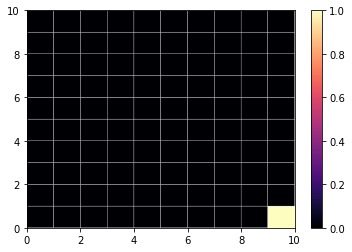

In [110]:
print("Heat map of reward function 1")
plt.pcolor(np.flipud(reward_fn1), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

Heat map of reward function 2


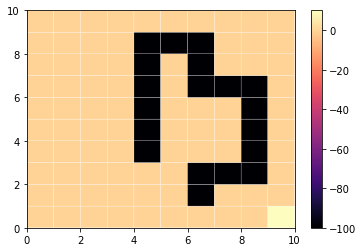

In [111]:
print("Heat map of reward function 2")
plt.pcolor(np.flipud(reward_fn2), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

In [112]:
S = range(0, 100)
state_space = np.transpose(np.array(S).reshape(10,10))
A = ['U', 'D', 'L', 'R']
arrows = {'U' : u'\u2191', 'D' : u'\u2193', 'L' : u'\u2190', 'R' : u'\u2192'}
num_states = 100
w = 0.1
gamma = 0.8
P = {}

<h2> Question 2 </h2>

In [113]:
optimal_state_values_r1 = get_optimal_state_value_fn(reward_fn1, S, A, gamma, 0.01, state_space, w)

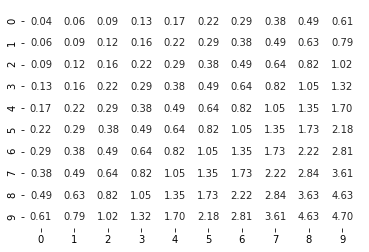

In [114]:
sns.heatmap(state_space, annot=optimal_state_values_r1, fmt='.2f', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Question 3 </h2>

Heat map of Optimal State Values for reward 1


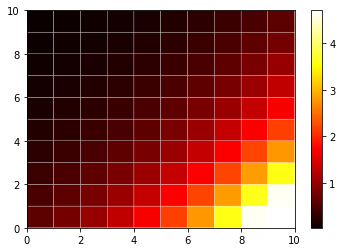

In [115]:
print("Heat map of Optimal State Values for reward 1")
plt.pcolor(np.flipud(optimal_state_values_r1), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()

<h2>Question 5</h2>

In [116]:
optimal_policy_r1 = get_optimal_policy(reward_fn1, S, A, gamma, state_space, w, optimal_state_values_r1)

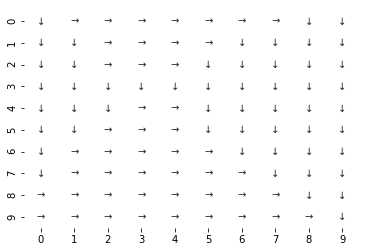

In [117]:
sns.heatmap(state_space, annot=optimal_policy_r1, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Question 6 </h2>

In [118]:
optimal_state_values_r2 = get_optimal_state_value_fn(reward_fn2, S, A, gamma, 0.01, state_space, w)

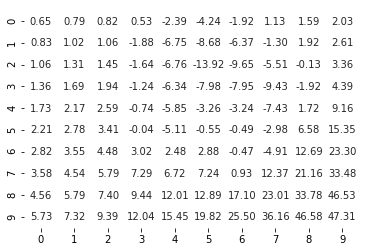

In [119]:
sns.heatmap(state_space, annot=optimal_state_values_r2, fmt='.2f', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Question 7 </h2>

Heat map of Optimal State Values for reward 2


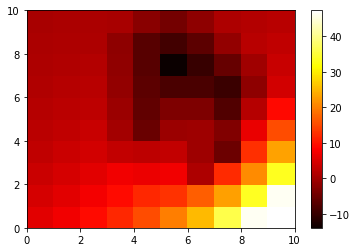

In [120]:
print("Heat map of Optimal State Values for reward 2")
plt.pcolor(np.flipud(optimal_state_values_r2), cmap = 'hot')
plt.colorbar()
plt.show()

<h2> Question 9 </h2>

In [121]:
optimal_policy_r2 = get_optimal_policy(reward_fn2, S, A, gamma, state_space, w, optimal_state_values_r2)

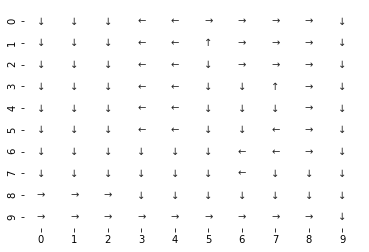

In [122]:
sns.heatmap(state_space, annot=optimal_policy_r2, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Inverse Reinforcement Learning </h2>

In [123]:
def get_irl_trans_prob(state_space, A, S, w):
    """
    Returns a dictionary which gives the transition probability for each action, current state, next state combination
    """

    Pa = {}
    dim = state_space.shape[0] * state_space.shape[1]

    for a in A:

        Pa[arrows[a]] = np.zeros((dim, dim))

        for i in S:
            for j in S:
                Pa[arrows[a]][i,j] = get_transition_probability(state_space, i, j, a, w, A)
                
    return Pa

In [124]:
def get_irl_opt_trans_prob(state_space, S, Pa, ground_truth_opt_policy):
    """
    For all states, get the ground truth optimal policy calculated earlier and get the corresponding transition 
    probability for that optimal policy
    """

    dim = state_space.shape[0] * state_space.shape[1]
    Pa1 = np.zeros((dim, dim))  
    state_optimal_dir = {}

    for i in S:
        state_optimal_dir[i] = ground_truth_opt_policy[pos(i, state_space)]
        for j in S:
            Pa1[i,j] = Pa[state_optimal_dir[i]][i, j]
            
    return Pa1, state_optimal_dir

In [125]:
def get_P_IP(S, state_optimal_dir, Pa1, Pa, gamma):
    """
    Calculate the first and second values in 'D' for the LP solver
    P calculates the (Pa1 − Pa)(I − γPa1)−1
    I_P calculates the corresponding identity matrix - 
    300*100 (3 states not equal to optimal policy * 100 * 100 state combination)
    
    Hence I_P is three 1s repeated diagonally
    """

    dim = state_space.shape[0] * state_space.shape[1]
    P = np.empty((0, dim))
    I_P = np.empty((0, dim))


    for i in S:
        for a in set(arrows.values()) - set(state_optimal_dir[i]):
            Q = - np.dot((Pa1[i, :] - Pa[a][i, :]), np.linalg.inv(np.identity(dim) - gamma*Pa1))
            P = np.row_stack((P, Q))

            identity = np.zeros((1, dim))
            identity[0][i] = 1
            I_P = np.row_stack((I_P, identity))
    
    return P, I_P

In [126]:
def get_lp_params(A, state_space, Rmax, P, I_P, lam):
    """
    Calculates the B,C,D matrices for the LP solver
    """
    
    Dcol = len(A) - 1
    dim = state_space.shape[0] * state_space.shape[1]
    
    Rmax_vec = np.repeat(Rmax, dim).reshape((dim, 1))
    
    D = np.empty((0, dim*Dcol))
    B = np.empty((0, 1))
    I = np.identity(dim)
    O = np.zeros((dim, dim))
    OB = np.zeros((dim, 1))
    O_P = np.zeros(P.shape)
    O_B = np.zeros((dim*Dcol, 1))

    D = np.row_stack((D, np.column_stack((P, I_P, O_P))))
    B = np.row_stack((B, O_B))
    D = np.row_stack((D, np.column_stack((P, O_P, O_P))))
    B = np.row_stack((B, O_B))

    D = np.row_stack((D, np.column_stack((-I, O, -I))))
    B = np.row_stack((B, OB))
    D = np.row_stack((D, np.column_stack((I, O, -I))))
    B = np.row_stack((B, OB))
    D = np.row_stack((D, np.column_stack((I, O, O))))
    B = np.row_stack((B, Rmax_vec))
    D = np.row_stack((D, np.column_stack((-I, O, O))))
    B = np.row_stack((B, Rmax_vec))

    Crow = (dim, 1)
    C = np.row_stack((np.zeros(Crow), np.ones(Crow), -lam*np.ones(Crow)))   

    C = matrix(C)
    D = matrix(D)
    B = matrix(B)
    
    return B, C, D

In [127]:
def irl(reward_fn, ground_truth_opt_policy, A, S, w, lam_list, gamma = 0.8):
    """
    Get the Rmax, Pa and Pa1
    With those get P and I_P and get the optimal state values and policy for varying lambdas
    Calculate accuracies
    """
    
    Rmax = np.max(reward_fn)
    Pa = get_irl_trans_prob(state_space, A, S, w)
    Pa1, state_optimal_dir = get_irl_opt_trans_prob(state_space, S, Pa, ground_truth_opt_policy)
    
    P, I_P = get_P_IP(S, state_optimal_dir, Pa1, Pa, gamma)
    

    lam_vs_acc = []
    for lam in lam_list:
    
        extracted_reward_fn = np.array(extract_reward_fn(A, state_space, Rmax, P, I_P, lam))

        V = get_optimal_state_value_fn(extracted_reward_fn, S, A, gamma, 0.01, state_space, w)
        OAS = get_optimal_policy(extracted_reward_fn, S, A, gamma, state_space, w, V)
        OES = ground_truth_opt_policy
        lam_vs_acc.append(np.sum(OAS == OES) / len(S))
        
    return lam_vs_acc, extracted_reward_fn

In [128]:
def extract_reward_fn(A, state_space, Rmax, P, I_P, lam):
    """
    LP solver method - Given the input matrices, find the output column
    return the reward function
    """
    
    B, C, D = get_lp_params(A, state_space, Rmax, P, I_P, lam)
    solvers.options['show_progress'] = False
    sol=solvers.lp(C,D,B)

    extracted_reward_fn = sol['x'][:100]
    extracted_reward_fn = np.matrix(extracted_reward_fn).reshape(10, 10).T
    
    return extracted_reward_fn

<h2> Question 11 </h2>

In [129]:
lambda_range = np.arange(0, 501) / 100
lam_vs_acc, _ = irl(reward_fn1, optimal_policy_r1, A, S, w, lambda_range)
lam_max_1 = lambda_range[np.argmax(lam_vs_acc)]

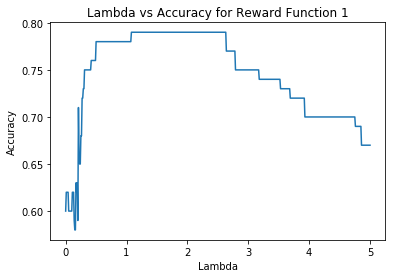

In [130]:
plt.plot(lambda_range, lam_vs_acc)
plt.title("Lambda vs Accuracy for Reward Function 1")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

<h2> Question 12 </h2>

In [131]:
print("The highest accuracy is ", np.max(lam_vs_acc))
print("The lambda value with highest accuracy is ", lam_max_1)

The highest accuracy is  0.79
The lambda value with highest accuracy is  1.08


<h2> Question 13 </h2>

In [132]:
_, extracted_reward_fn_1 = irl(reward_fn1, optimal_policy_r1, A, S, w, [lam_max_1])


Heat Map - Reward Function 1


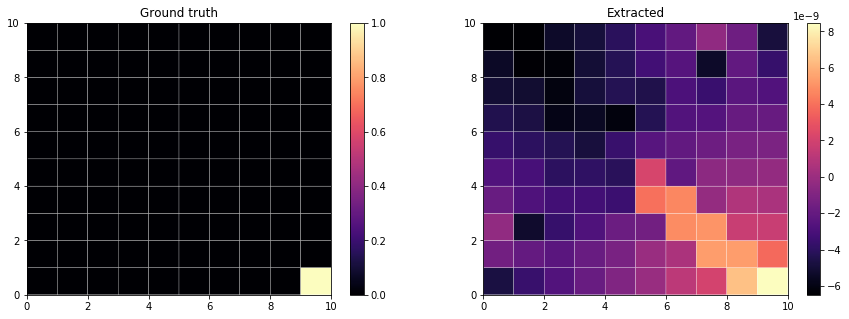

In [133]:
print("\nHeat Map - Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(reward_fn1), edgecolors = 'white', cmap = 'magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
plt.pcolor(np.flipud(extracted_reward_fn_1), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

<h2> Question 14 </h2>

Heat map of Optimal State Values for Reward Function 1


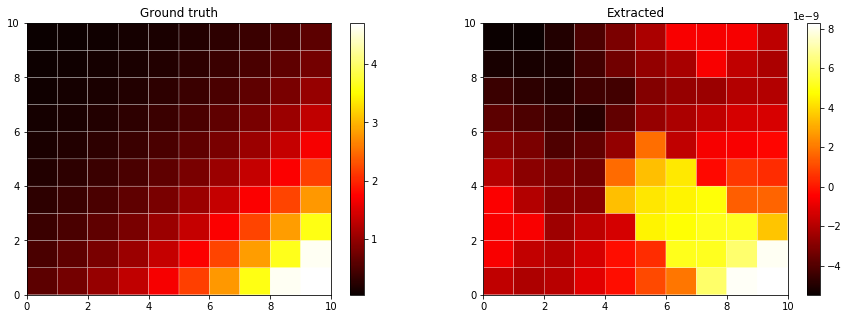

In [134]:
print("Heat map of Optimal State Values for Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(optimal_state_values_r1), edgecolors = 'white', cmap = 'hot')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
optimal_state_values_extracted_r1 = get_optimal_state_value_fn(extracted_reward_fn_1, S, A, gamma, 0.01, state_space, w)
plt.pcolor(np.flipud(optimal_state_values_extracted_r1), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()

<h2> Question 16 </h2>


Optimal Policy - Reward Function 1


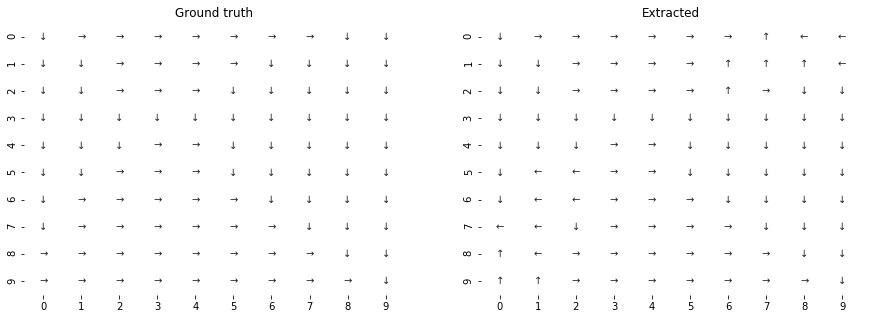

In [135]:
print("\nOptimal Policy - Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
sns.heatmap(state_space, annot=optimal_policy_r1, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))

plt.subplot(1,2,2)
plt.title("Extracted")
optimal_policy_extracted_r1 = get_optimal_policy(extracted_reward_fn_1, S, A, gamma, state_space, w, 
                                                 optimal_state_values_extracted_r1)
sns.heatmap(state_space, annot=optimal_policy_extracted_r1, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))
plt.show()

<h2> Question 18 </h2>

In [136]:
lambda_range = np.arange(0, 501) / 100
lam_vs_acc, _ = irl(reward_fn2, optimal_policy_r2, A, S, w, lambda_range)

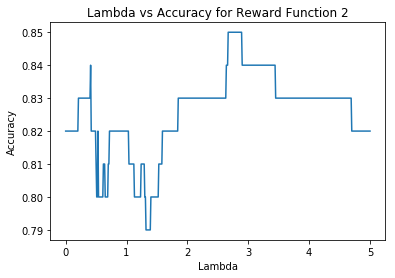

In [137]:
plt.plot(lambda_range, lam_vs_acc)
plt.title("Lambda vs Accuracy for Reward Function 2")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

<h2> Question 19 </h2>

In [138]:
print("The highest accuracy is ", np.max(lam_vs_acc))
lam_max_2 = lambda_range[random.choice(np.argwhere(lam_vs_acc == np.amax(lam_vs_acc)).flatten().tolist())]
#randomly choosing one lambda out of all lambdas with highest accuracy
print("The lambda value with highest accuracy is ", lam_max_2)

The highest accuracy is  0.85
The lambda value with highest accuracy is  2.77


<h2> Question 20 </h2>

In [139]:
_, extracted_reward_fn_2 = irl(reward_fn2, optimal_policy_r2, A, S, w, [lam_max_2])


Heat Map - Reward Function 2


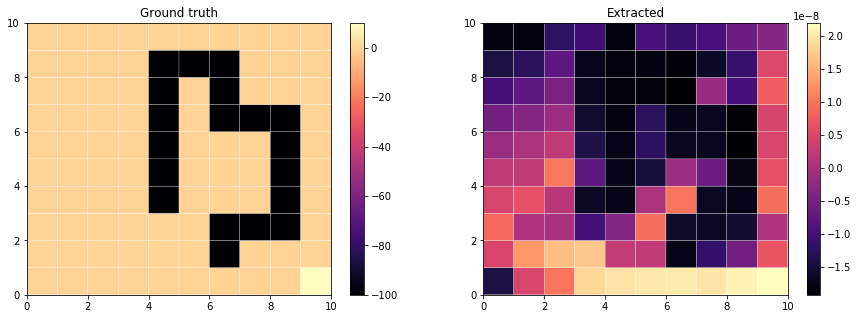

In [140]:
print("\nHeat Map - Reward Function 2")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(reward_fn2), edgecolors = 'white', cmap = 'magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
plt.pcolor(np.flipud(extracted_reward_fn_2), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

<h2> Question 21 </h2>

Heat map of Optimal State Values for Reward Function 2


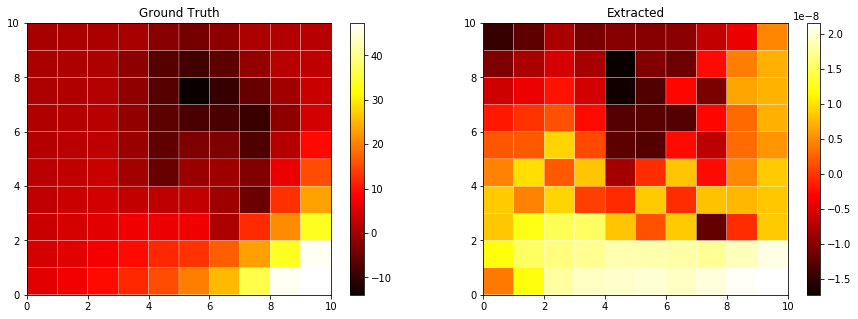

In [141]:
print("Heat map of Optimal State Values for Reward Function 2")

fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground Truth")
plt.pcolor(np.flipud(optimal_state_values_r2), edgecolors = 'white', cmap = 'hot')
plt.colorbar()


plt.subplot(1,2,2)
plt.title("Extracted")
optimal_state_values_extracted_r2 = get_optimal_state_value_fn(extracted_reward_fn_2, S, A, gamma, 0.01, state_space, w)
plt.pcolor(np.flipud(optimal_state_values_extracted_r2), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()

<h2> Question 23 </h2>


Optimal Policy - Reward Function 2


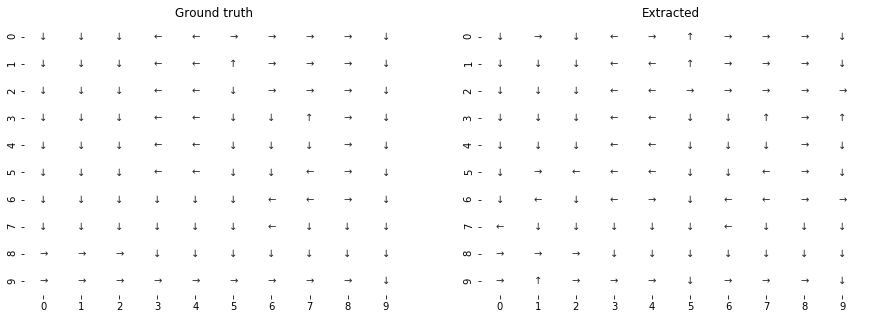

In [142]:
print("\nOptimal Policy - Reward Function 2")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
sns.heatmap(state_space, annot=optimal_policy_r2, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))

plt.subplot(1,2,2)
plt.title("Extracted")
optimal_policy_extracted_r2 = get_optimal_policy(extracted_reward_fn_2, S, A, gamma, state_space, w, 
                                                 optimal_state_values_extracted_r2)
sns.heatmap(state_space, annot=optimal_policy_extracted_r2, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))
plt.show()